In [8]:
import matplotlib.pyplot as plt
import re

filenames = ["data\k05_12.txt"]
file_name = filenames[0]

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\phel\AppData\Local\Temp\ipykernel_16424\783259792.py:4: SyntaxWarning: invalid escape sequence '\k'
  filenames = ["data\k05_12.txt"]


In [9]:
ch1, ch2, ch3 = [], [], []

with open(file_name, "r") as file:
    for line in file:
        match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
        # match = re.search(r"EMG_RAW=(\d+), EMG_FILT=(\d+)", line)
        if match:
            ch1.append(int(match.group(1)))
            ch2.append(int(match.group(2)))
            ch3.append(int(match.group(3)))

time = [i / 100000 for i in range(len(ch1))]



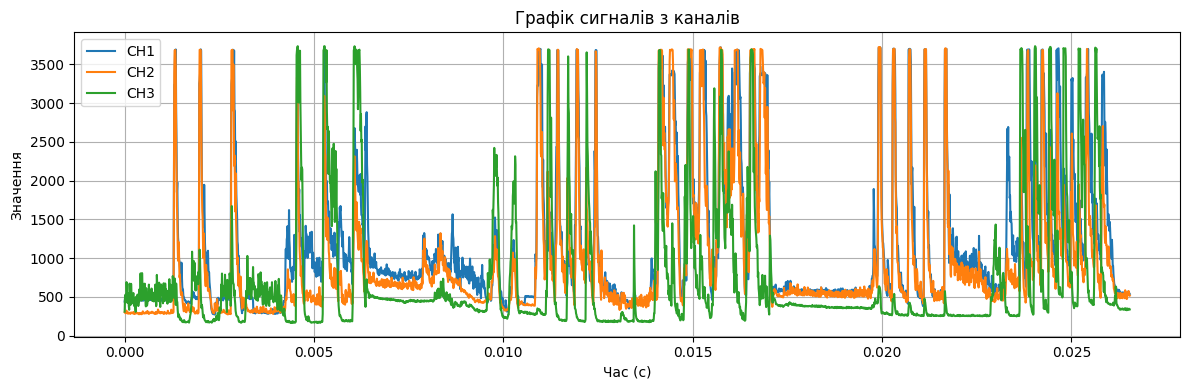

In [13]:
plt.figure(figsize=(12, 4))


plt.plot(time, ch1, label="CH1")
plt.plot(time, ch2, label="CH2")
plt.plot(time, ch3, label="CH3")


plt.title("Графік сигналів з каналів")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Loading data from data/k05_12.txt...
Loaded 2655 samples
EMG Filter initialized - EXACT C replica
Window=50, Threshold=500
Processing through custom filter...
EMG_DATA: RAW=440, FILTERED=440
EMG_DATA: RAW=478, FILTERED=465
EMG_DATA: RAW=3267, FILTERED=721
EMG_DATA: RAW=926, FILTERED=1316
EMG_DATA: RAW=285, FILTERED=299
EMG_DATA: RAW=949, FILTERED=1355
EMG_DATA: RAW=856, FILTERED=1102
EMG_DATA: RAW=813, FILTERED=861
EMG_DATA: RAW=991, FILTERED=863
EMG_DATA: RAW=857, FILTERED=911
EMG_DATA: RAW=379, FILTERED=733
EMG_DATA: RAW=3134, FILTERED=1247
EMG_DATA: RAW=2356, FILTERED=1345
EMG_DATA: RAW=527, FILTERED=667
EMG_DATA: RAW=528, FILTERED=519
EMG_DATA: RAW=1815, FILTERED=1992
EMG_DATA: RAW=2027, FILTERED=2003
EMG_DATA: RAW=2393, FILTERED=3007
EMG_DATA: RAW=572, FILTERED=596
EMG_DATA: RAW=574, FILTERED=581
EMG_DATA: RAW=1455, FILTERED=1285
EMG_DATA: RAW=484, FILTERED=1278
EMG_DATA: RAW=914, FILTERED=1367
EMG_DATA: RAW=668, FILTERED=750
EMG_DATA: RAW=1039, FILTERED=1737
EMG_DATA: RAW=3312, F

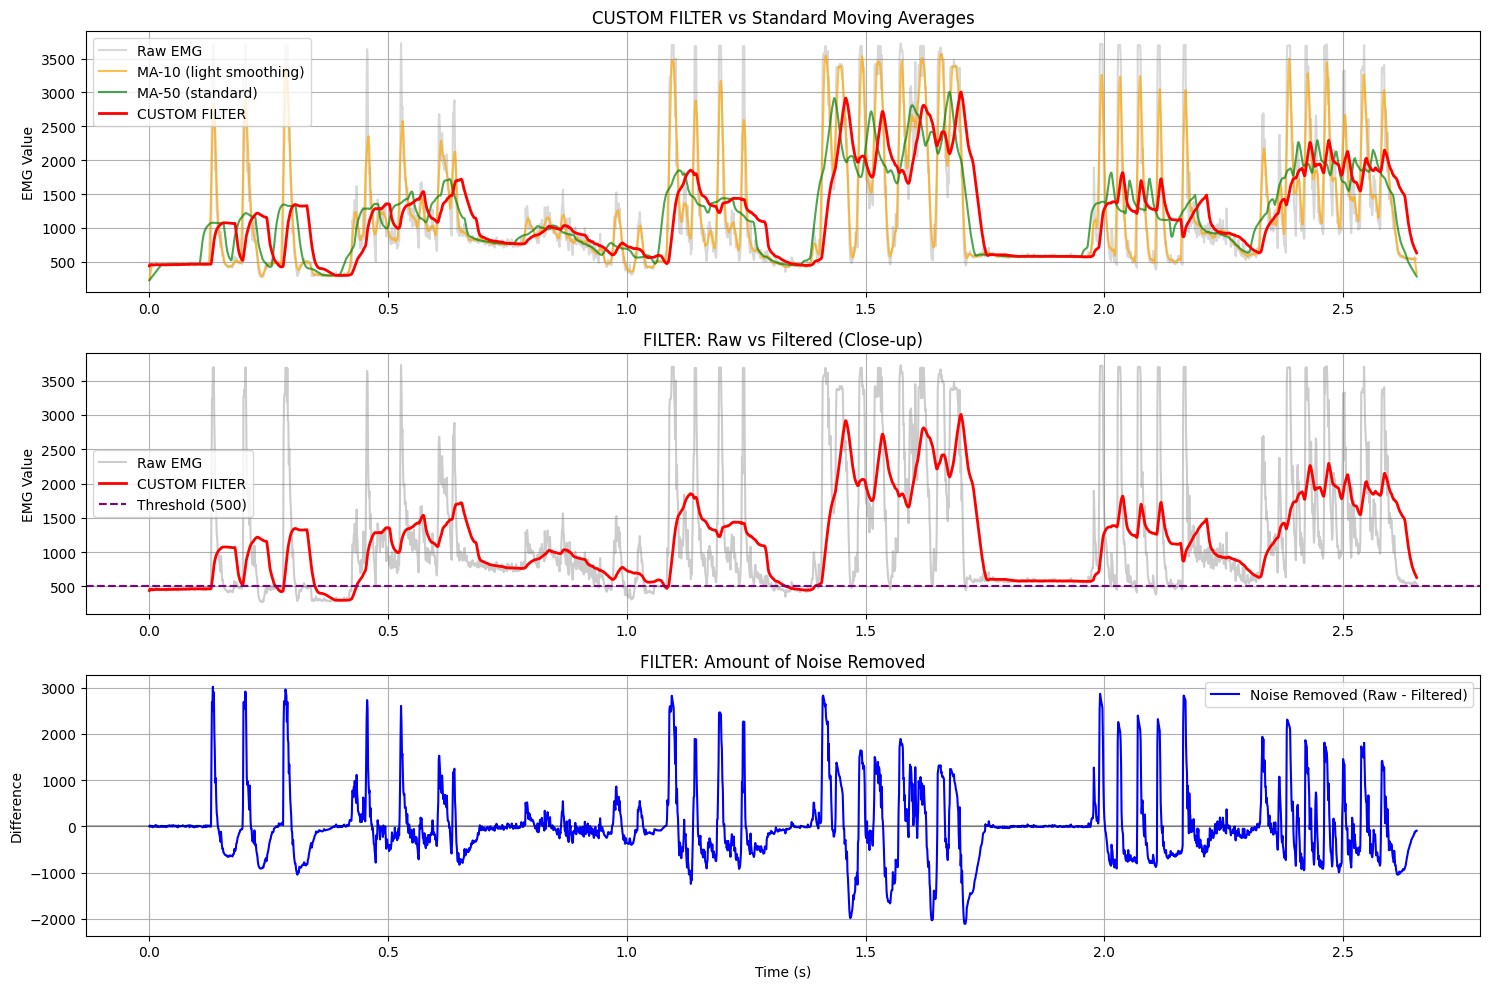


Filter final state:
  Buffer full: True
  Current index: 5
  Current filtered value: 631


In [16]:
import numpy as np
from typing import List, Tuple

class EMGFilter:
    def __init__(self, window_size: int = 50, threshold: int = 500, 
                 servo_rest_angle: int = 0, servo_active_angle: int = 90):
        self.window_size = window_size
        self.threshold = threshold
        self.servo_rest_angle = servo_rest_angle
        self.servo_active_angle = servo_active_angle
        
        self.buf = [0] * window_size  # uint16_t buf[EMG_WINDOW_SIZE]
        self.sum = 0                  # uint32_t sum
        self.filtered = 0             # uint16_t filtered
        self.index = 0                # uint16_t index
        self.full = False             # uint8_t full
        self.servo_angle = servo_rest_angle  # uint8_t servoAngle
        self.last_raw_value = 0       # uint16_t lastRawValue
        self.last_filtered_value = 0  # uint16_t lastFilteredValue
        
        self.activated = False
        self.peak_start_time = 0
        
        print(f"EMG Filter initialized - EXACT C replica")
        print(f"Window={window_size}, Threshold={threshold}")

    def update_filter(self, raw_value: int) -> None:
        self.last_raw_value = raw_value
        
        i = self.index
        old_value = self.buf[i]
        self.buf[i] = raw_value
        
        if self.full:
            self.sum += raw_value - old_value  
        else:
            self.sum += raw_value
        
        count = self.window_size if self.full else (i + 1)
        self.filtered = self.sum // count 
        self.last_filtered_value = self.filtered
        
        self.index += 1
        if self.index >= self.window_size:
            self.index = 0
            self.full = True

    def process_data(self, raw_data: List[int]) -> Tuple[List[int], List[int]]:
        filtered_results = []
        servo_angles = []
        
        for i, raw_val in enumerate(raw_data):
            self.update_filter(raw_val)
            filtered_results.append(self.filtered)
            servo_angles.append(self.servo_angle)
            
            if i % 100 == 0:
                print(f"EMG_DATA: RAW={self.last_raw_value}, FILTERED={self.last_filtered_value}")
        
        return filtered_results, servo_angles

def load_emg_data(filename: str) -> List[int]:
    raw_data = []
    
    with open(filename, "r") as file:
        for line in file:
            # match = re.search(r"EMG_RAW=(\d+)", line)
            match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
            if match:
                raw_data.append(int(match.group(1)))
    
    return raw_data

def plot_filter_performance(raw_data: List[int], custom_filtered: List[int], 
                                emg_filter: EMGFilter, sample_rate: float = 1000):
    """Plot focusing on custom filter performance"""
    
    time = [i / sample_rate for i in range(len(raw_data))]
    
    ma_10 = np.convolve(raw_data, np.ones(10)/10, mode='same')
    ma_50 = np.convolve(raw_data, np.ones(50)/50, mode='same')  
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.3, color='gray')
    plt.plot(time, ma_10, label='MA-10 (light smoothing)', alpha=0.7, color='orange')
    plt.plot(time, ma_50, label='MA-50 (standard)', alpha=0.7, color='green')
    plt.plot(time, custom_filtered, label='CUSTOM FILTER', linewidth=2, color='red')
    plt.title('CUSTOM FILTER vs Standard Moving Averages')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.4, color='gray')
    plt.plot(time, custom_filtered, label='CUSTOM FILTER', linewidth=2, color='red')
    plt.axhline(y=emg_filter.threshold, color='purple', linestyle='--', 
                label=f'Threshold ({emg_filter.threshold})')
    plt.title('FILTER: Raw vs Filtered (Close-up)')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    difference = np.array(raw_data) - np.array(custom_filtered)
    plt.plot(time, difference, label='Noise Removed (Raw - Filtered)', color='blue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('FILTER: Amount of Noise Removed')
    plt.xlabel('Time (s)')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_filter_performance(raw_data: List[int], custom_filtered: List[int]):
    """Analyze how well filter works"""
    raw_array = np.array(raw_data)
    filtered_array = np.array(custom_filtered)
    
    print("CUSTOM FILTER PERFORMANCE ANALYSIS")
    
    noise_removed = raw_array - filtered_array
    avg_noise_reduction = np.mean(np.abs(noise_removed))
    
    print(f"Raw signal stats:")
    print(f"  Mean: {np.mean(raw_array):.1f}, Std: {np.std(raw_array):.1f}")
    print(f"  Min: {np.min(raw_array)}, Max: {np.max(raw_array)}")
    
    print(f"\nFiltered signal stats:")
    print(f"  Mean: {np.mean(filtered_array):.1f}, Std: {np.std(filtered_array):.1f}")
    print(f"  Min: {np.min(filtered_array)}, Max: {np.max(filtered_array)}")
    
    print(f"\nFilter performance:")
    print(f"  Average noise removed: {avg_noise_reduction:.1f} units")
    print(f"  Standard deviation reduction: {np.std(raw_array) - np.std(filtered_array):.1f} units")
    print(f"  Smoothing factor: {np.std(raw_array)/np.std(filtered_array):.2f}x smoother")

if __name__ == "__main__":
    filename = "data/k05_12.txt"
    print(f"Loading data from {filename}...")
    raw_data = load_emg_data(filename)
    print(f"Loaded {len(raw_data)} samples")
    
    my_filter = EMGFilter(
        window_size=50,       
        threshold=500,        
        servo_rest_angle=0,
        servo_active_angle=90
    )
    
    print("Processing through custom filter...")
    my_filtered, servo_angles = my_filter.process_data(raw_data)
    
    analyze_filter_performance(raw_data, my_filtered)
    plot_filter_performance(raw_data, my_filtered, my_filter)
    
    print(f"\nFilter final state:")
    print(f"  Buffer full: {my_filter.full}")
    print(f"  Current index: {my_filter.index}")
    print(f"  Current filtered value: {my_filter.filtered}")

Loading EMG data from data/k05_12.txt...
Channel: 1 (Flexor/Close)
Loaded 2655 samples

Generating single graph comparison...


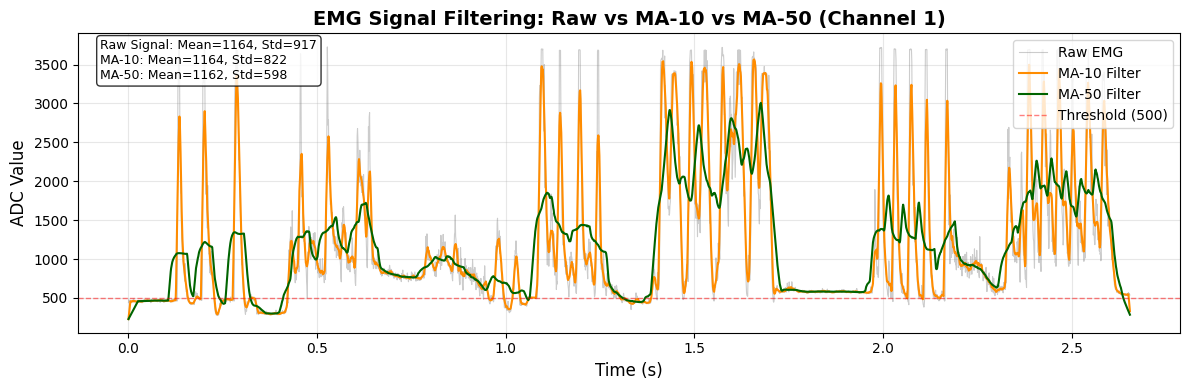


FILTER COMPARISON SUMMARY

Raw Signal:
  Samples: 2655
  Mean: 1164.2
  Std Dev: 916.9
  Range: 273 - 3727

MA-10 Filter:
  Mean: 1163.7
  Std Dev: 822.1 (reduction: 10%)

MA-50 Filter:
  Mean: 1161.8
  Std Dev: 597.6 (reduction: 35%)


In [19]:
def load_emg_data(filename: str, channel: int = 0) -> List[int]:
    """Load EMG data from log file for specified channel (0=CH1, 1=CH2, 2=CH3)"""
    raw_data = []
    
    with open(filename, "r") as file:
        for line in file:
            match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
            if match:
                raw_data.append(int(match.group(channel + 1)))
    
    return raw_data

def calculate_moving_average(data: List[int], window_size: int) -> np.ndarray:
    """Calculate moving average using convolution"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def plot_single_graph_comparison(raw_data: List[int], sample_rate: float = 1000):
    """Plot raw signal, MA-10, and MA-50 filters on single graph"""
    
    ma_10 = calculate_moving_average(raw_data, 10)
    ma_50 = calculate_moving_average(raw_data, 50)
    
    time = np.arange(len(raw_data)) / sample_rate
    
    plt.figure(figsize=(12, 4))
    
    plt.plot(time, raw_data, color='gray', alpha=0.4, linewidth=0.8, label='Raw EMG')
    plt.plot(time, ma_10, color='darkorange', linewidth=1.5, label='MA-10 Filter')
    plt.plot(time, ma_50, color='darkgreen', linewidth=1.5, label='MA-50 Filter')
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('ADC Value', fontsize=12)
    plt.title('EMG Signal Filtering: Raw vs MA-10 vs MA-50 (Channel 1)', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.axhline(y=500, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Threshold (500)')
    
    plt.legend(loc='upper right', fontsize=10)
    
    stats_text = (f'Raw Signal: Mean={np.mean(raw_data):.0f}, Std={np.std(raw_data):.0f}\n'
                  f'MA-10: Mean={np.mean(ma_10):.0f}, Std={np.std(ma_10):.0f}\n'
                  f'MA-50: Mean={np.mean(ma_50):.0f}, Std={np.std(ma_50):.0f}')
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=9, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()    
    plt.show()
    
    return ma_10, ma_50

def print_simple_summary(raw_data: List[int], ma_10: np.ndarray, ma_50: np.ndarray):
    """Print simple summary"""
    raw_array = np.array(raw_data)
    
    print("\n" + "="*50)
    print("FILTER COMPARISON SUMMARY")
    print("="*50)
    
    print(f"\nRaw Signal:")
    print(f"  Samples: {len(raw_array)}")
    print(f"  Mean: {np.mean(raw_array):.1f}")
    print(f"  Std Dev: {np.std(raw_array):.1f}")
    print(f"  Range: {np.min(raw_array)} - {np.max(raw_array)}")
    
    print(f"\nMA-10 Filter:")
    print(f"  Mean: {np.mean(ma_10):.1f}")
    print(f"  Std Dev: {np.std(ma_10):.1f} (reduction: {100*(1-np.std(ma_10)/np.std(raw_array)):.0f}%)")
    
    print(f"\nMA-50 Filter:")
    print(f"  Mean: {np.mean(ma_50):.1f}")
    print(f"  Std Dev: {np.std(ma_50):.1f} (reduction: {100*(1-np.std(ma_50)/np.std(raw_array)):.0f}%)")
    
if __name__ == "__main__":
    FILENAME = "data/k05_12.txt" 
    CHANNEL = 0  # 0 = CH1, 1 = CH2, 2 = CH3
    
    print(f"Loading EMG data from {FILENAME}...")
    print(f"Channel: {CHANNEL + 1} (Flexor/Close)")
    
    try:
        raw_data = load_emg_data(FILENAME, CHANNEL)
        print(f"Loaded {len(raw_data)} samples")
        
        if len(raw_data) == 0:
            print("ERROR: No data loaded. Check file path and format.")
            exit(1)
        
        print("\nGenerating single graph comparison...")
        ma_10, ma_50 = plot_single_graph_comparison(raw_data)
        
        print_simple_summary(raw_data, ma_10, ma_50)
        
    except FileNotFoundError:
        print(f"ERROR: File '{FILENAME}' not found.")
        print("Please ensure the data file exists in the specified location.")
    except Exception as e:
        print(f"ERROR: {e}")